In [1]:
# Installation des packages
# !pip install numpy pandas matplotlib scikit-learn scipy seaborn
print('Done')

Done


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pformat

# Prétraitement des données
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline

# Modèles
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Évaluation des modèles
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from scipy.stats import spearmanr

# Validation croisée et recherche de modèle
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold


from sklearn.preprocessing import PolynomialFeatures

In [5]:
raw_data_x = pd.read_csv("data/Data_X.csv", index_col='ID')
raw_dataNew_x = pd.read_csv("data/DataNew_X.csv", index_col='ID')
raw_data_y = pd.read_csv("data/Data_Y.csv", index_col='ID')

In [6]:
data_xy = pd.merge(raw_data_x, raw_data_y, on='ID').copy()

In [7]:
data_fr = data_xy.drop('COUNTRY', axis=1).copy()

(1494,)

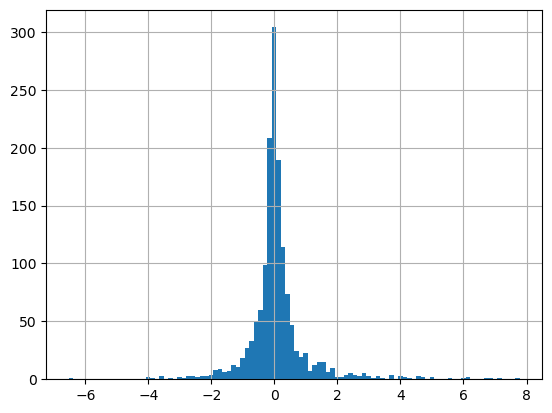

In [9]:
data_fr['TARGET'].hist(bins=100)
display(data_fr['TARGET'].shape)

In [39]:
Q1 = data_fr['TARGET'].quantile(0.25) # get the 25th percentile
Q3 = data_fr['TARGET'].quantile(0.75) # get the 75th percentile
IQR = Q3 - Q1 # calculate the interquartile range

coef = 0.3
filtered_data = data_fr[(data_fr['TARGET'] < Q1 - coef * IQR) | (data_fr['TARGET'] > Q3 + coef * IQR)]

<AxesSubplot:>

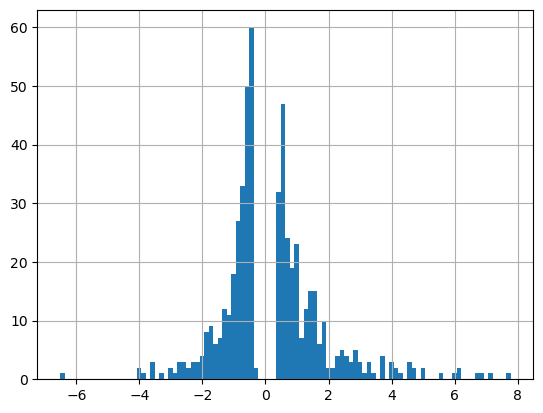

In [40]:
filtered_data['TARGET'].hist(bins=100)
display(filtered_data['TARGET'].shape)

In [6]:
X = data_fr.drop('TARGET', axis=1)
y = data_fr['TARGET']


In [48]:
scaler = RobustScaler()
t_data = scaler.fit_transform(data_fr)
t_data = pd.DataFrame(t_data, columns=data_fr.columns)
X = t_data.drop('TARGET', axis=1)
y = t_data['TARGET']

In [41]:
X = filtered_data.drop('TARGET', axis=1)
y = filtered_data['TARGET']


<AxesSubplot:>

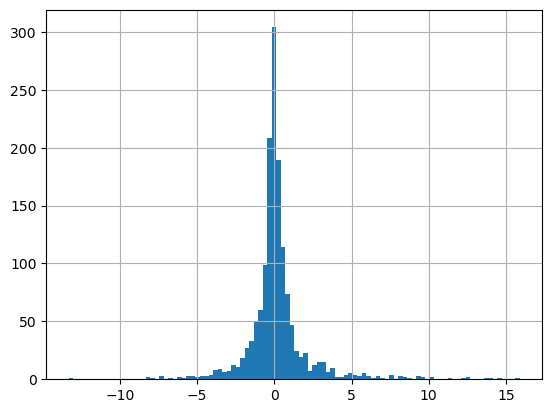

In [12]:
t_data['TARGET'].hist(bins=100)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
from fonctions_EVAL import r2_scoring, rmse_scoring, spearman_scoring
from sklearn.impute import KNNImputer
from sklearn.model_selection import RandomizedSearchCV

scorers = {
    'r2': r2_scoring,
    'rmse': rmse_scoring,
    'spearmanr': spearman_scoring,
}

    # 'selection': [None] + [PolynomialFeatures(degree=deg) for deg in [1, 2, 3]],
common_params = {
    'imputer': [SimpleImputer(strategy=strategy) for strategy in ['mean', 'median']],
    'selection': [None],
    'scaler': [None, StandardScaler(), MinMaxScaler(), RobustScaler()],
}

params = {
    'linear': {
        **common_params,
        'model__fit_intercept': [True, False],
    },
    'ridge': {
        **common_params,
        'model__alpha': np.logspace(-10, 10).tolist()
    },
    'lasso': {
        **common_params,
        'model__alpha': np.logspace(-10, 10).tolist()
    },
    'knn': {
        **common_params,
        'model__n_neighbors': range(5, 100),
        'model__weights': ['uniform', 'distance'],
        'model__metric': ['euclidean', 'manhattan', 'minkowski']
    },
    'decision_tree': {
        **common_params,
        'model__max_depth': range(2, 30),
        'model__min_samples_split': range(2, 20),
        'model__min_samples_leaf': range(2, 20),
    },
    'random_forest': {
        **common_params,
        'model__n_estimators': range(5, 100, 5),  
        'model__max_depth': range(2, 10),  
    }
}

pipelines = {
    'linear': Pipeline([
        ('imputer', None),
        ('selection', None), 
        ('scaler', None),
        ('model', LinearRegression())
    ]),
    'ridge': Pipeline([
        ('imputer', None),
        ('selection', None),
        ('scaler', None),
        ('model', Ridge())
    ]),
    'lasso': Pipeline([
        ('imputer', None),
        ('selection', None),
        ('scaler', None),
        ('model', Lasso())
    ]),
    'knn': Pipeline([
        ('imputer', None),
        ('selection', None),
        ('scaler', None),
        ('model', KNeighborsRegressor())
    ]),  
    'decision_tree': Pipeline([
        ('imputer', None),
        ('selection', None),
        ('scaler', None),
        ('model', DecisionTreeRegressor())
    ]),
    'random_forest': Pipeline([
        ('imputer', None),
        ('selection', None),
        ('scaler', None),
        ('model', RandomForestRegressor(n_jobs=-1))
    ])
}

n_iter_dict = {
    'linear': 300,
    'ridge': 300,
    'lasso': 300,
    'knn': 300,
    'decision_tree': 300,
    'random_forest': 30,
}
results = {}
cv_results = {'spearmanr': {}, 'r2': {}, 'rmse': {}}

print("Starting nested cross-validation for model selection and evaluation...\n")

for model_name, pipeline in pipelines.items():
    print(f"Cross-validation for {model_name.capitalize()} model...")
    # rs_inner = GridSearchCV(pipeline, params[model_name], cv=2, n_jobs=-1,scoring=scorers, refit='spearmanr')
    rs_inner = RandomizedSearchCV(pipeline, params[model_name], cv=4, n_jobs=-1, scoring=spearman_scoring, refit='spearmanr', n_iter=n_iter_dict[model_name], random_state=42, verbose=1, error_score=0)

    %time rs_inner.fit(X_train, y_train)
    print(rs_inner.best_params_)
    print(rs_inner.best_score_)

    # for metric in ['spearmanr', 'r2', 'rmse']:
    #     best_index = rs_inner.cv_results_['rank_test_'+metric].argmin()
    #     cv_results[metric][model_name] = rs_inner.cv_results_['mean_test_'+metric][best_index]
    
    results[model_name] = {
        'best_parameters': rs_inner.best_params_,
        'best_score': rs_inner.best_score_,
        # 'metrics': {
        #     'spearmanr': cv_results['spearmanr'][model_name],
        #     'r2': cv_results['r2'][model_name],
        #     'rmse': cv_results['rmse'][model_name]
        # },
        'y_pred': rs_inner.predict(X_test),
    }
    
    if model_name in ['linear', 'lasso', 'ridge']:
        results[model_name]['feature_importances'] = dict(zip(X.columns, rs_inner.best_estimator_.named_steps['model'].coef_))
    elif model_name in ['decision_tree', 'radom_forest']:
        results[model_name]['feature_importances'] = dict(zip(X.columns, rs_inner.best_estimator_.named_steps['model'].feature_importances_))
    else:
        print(f' No feature importance or coef found for {model_name.capitalize()}')   
    print(f"Score: {results[model_name]['best_score']:.3f}\n")
print('Done.')

Starting nested cross-validation for model selection and evaluation...

Cross-validation for Linear model...
Fitting 4 folds for each of 16 candidates, totalling 64 fits


C:\Users\coren\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 16 is smaller than n_iter=300. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Wall time: 4.21 s
{'selection': None, 'scaler': None, 'model__fit_intercept': False, 'imputer': SimpleImputer(strategy='median')}
0.22016204859493382
Score: 0.220

Cross-validation for Ridge model...
Fitting 4 folds for each of 300 candidates, totalling 1200 fits
Wall time: 1.87 s
{'selection': None, 'scaler': MinMaxScaler(), 'model__alpha': 10.481131341546874, 'imputer': SimpleImputer(strategy='median')}
0.23546597590592905
Score: 0.235

Cross-validation for Lasso model...
Fitting 4 folds for each of 300 candidates, totalling 1200 fits
Wall time: 2.84 s
{'selection': None, 'scaler': MinMaxScaler(), 'model__alpha': 0.0022229964825261957, 'imputer': SimpleImputer(strategy='median')}
0.2272355299071293
Score: 0.227

Cross-validation for Knn model...
Fitting 4 folds for each of 300 candidates, totalling 1200 fits
Wall time: 3.73 s
{'selection': None, 'scaler': MinMaxScaler(), 'model__weights': 'uniform', 'model__n_neighbors': 42, 'model__metric': 'euclidean', 'imputer': SimpleImputer()}
0

In [149]:
from pprint import pprint
# %%capture cap
print("Summary :\n")
# Displaying results
for model_name, pipeline in pipelines.items():
    print(f"{model_name.capitalize()} model:")
    print(f"  Scores")
    print(f"    Best CV score: {results[model_name]['best_score']:.5f}")
    # print(f"    Spearman     : {results[model_name]['metrics']['spearmanr']:.5f}")
    # print(f"    R2           : {results[model_name]['metrics']['r2']:.5f}")
    # print(f"    RMSE         : {results[model_name]['metrics']['rmse']:.5f}")
    best_parameters = results[model_name]['best_parameters'].copy()
    imputer = best_parameters['imputer']
    selection = best_parameters['selection']
    scaler = best_parameters['scaler']
    print(f"  Best Pipeline")
    print(f"    Imputer      : {imputer}")
    print(f"    Feature      : {selection}")
    print(f"    Scaler       : {scaler}")
    
    del best_parameters['imputer']
    del best_parameters['selection']
    del best_parameters['scaler']
    str_best_parameters = pformat(best_parameters)[1:-1] 
    str_best_parameters = ' '
    print(f"  Best parameters ", end='\n')
    for name, param in best_parameters.items():
        print(" " * 5 + f"{name} : {param},")
    print()    
   
    
# with open(f'output/{test_name}.txt', 'w') as f:
#     f.write(cap.stdout)

Summary :

Linear model:
  Scores
    Best CV score: 0.17513
  Best Pipeline
    Imputer      : SimpleImputer()
    Feature      : None
    Scaler       : None
  Best parameters 
     model__fit_intercept : False,

Ridge model:
  Scores
    Best CV score: 0.26857
  Best Pipeline
    Imputer      : SimpleImputer()
    Feature      : None
    Scaler       : MinMaxScaler()
  Best parameters 
     model__alpha : 68.66488450042998,

Lasso model:
  Scores
    Best CV score: 0.27162
  Best Pipeline
    Imputer      : SimpleImputer()
    Feature      : None
    Scaler       : MinMaxScaler()
  Best parameters 
     model__alpha : 0.014563484775012445,

Knn model:
  Scores
    Best CV score: 0.25094
  Best Pipeline
    Imputer      : SimpleImputer()
    Feature      : None
    Scaler       : RobustScaler()
  Best parameters 
     model__weights : uniform,
     model__n_neighbors : 88,
     model__metric : manhattan,

Decision_tree model:
  Scores
    Best CV score: 0.20374
  Best Pipeline
    Im

In [134]:
for metric in ['spearmanr', 'r2', 'rmse']:
    sorted_results = sorted(cv_results[metric].items(), key=lambda x: x[1], reverse=True)
    print(f"\nModel ranking for {metric}:")
    for i, (model_name, score) in enumerate(sorted_results):
        print(f"{i+1}. {model_name}: {score:.4}")


Model ranking for spearmanr:
1. random_forest: 0.6107
2. ridge: 0.5196
3. knn: 0.4923
4. lasso: 0.4855
5. decision_tree: 0.4381
6. linear: 0.01701

Model ranking for r2:
1. ridge: 0.1919
2. random_forest: 0.1793
3. lasso: 0.1405
4. decision_tree: 0.1213
5. knn: 0.1045
6. linear: -10.74

Model ranking for rmse:
1. knn: 0.0
2. ridge: -3.322
3. random_forest: -3.342
4. decision_tree: -3.393
5. lasso: -3.411
6. linear: -11.56


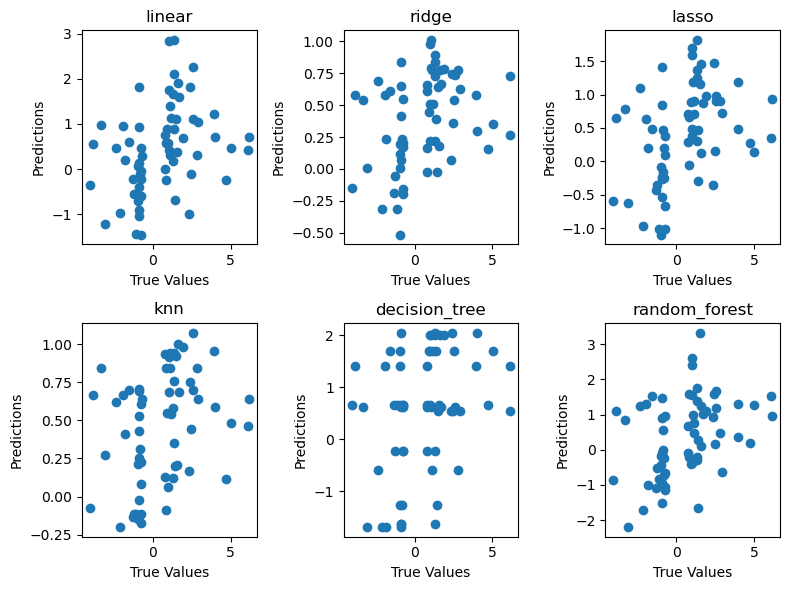

In [150]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8, 6))

for i, (model_name, result) in enumerate(results.items()):
    y_pred = result['y_pred']
    row, col = i // 3, i % 3
    axs[row, col].scatter(y_test, y_pred)
    axs[row, col].set_xlabel('True Values')
    axs[row, col].set_ylabel('Predictions')
    axs[row, col].set_title(model_name)

plt.tight_layout()
plt.show()

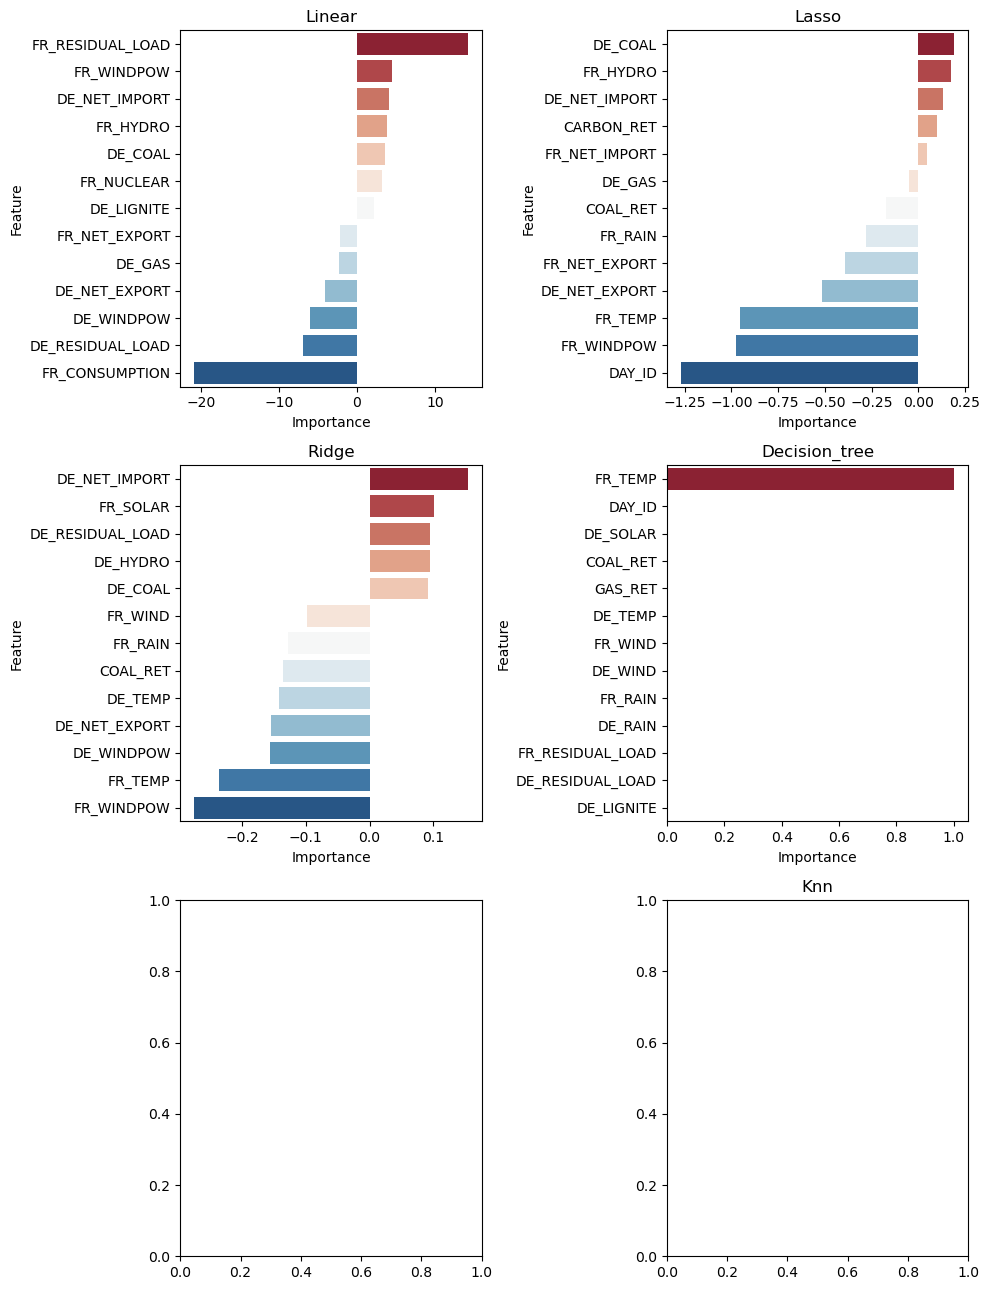

In [127]:
n_rows = 3
n_cols = 2
n = 13
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 13))
axs = axs.flatten()

def foo(ax, model_name, results):
    importances = results[model_name].get('feature_importances', None)
    if importances :
        importances_df = pd.DataFrame.from_dict(importances, orient='index', columns=['importance'])
        importances_df = importances_df.sort_values(by='importance', key=lambda x: x.abs(), ascending=False)
        importances_df = pd.DataFrame(importances_df.head(n))
        importances_df.sort_values('importance', ascending=False, inplace=True)
        sns.barplot(data=importances_df, y=importances_df.index, x='importance', palette='RdBu', ax=ax)
        ax.set_title(f'{model_name.capitalize()}')
        ax.set_xlabel('Importance')
        ax.set_ylabel('Feature')

foo(axs[0], 'linear', results)
foo(axs[1], 'lasso', results)
foo(axs[2], 'ridge', results)
foo(axs[3], 'decision_tree', results)
foo(axs[4], 'random_forest', results)
axs[5].set_title('Knn')

plt.tight_layout()
plt.show()

In [ ]:
# # All parameters
# params = {
#     'linear': {
#         **common_params,
#         'model__fit_intercept': [True, False],
#     },
#     'ridge': {
#         **common_params,
#         'model__alpha': np.logspace(start=-3, stop=3).tolist()
#     },
#     'lasso': {
#         **common_params,
#         'model__alpha': np.logspace(start=-3, stop=3).tolist()
#     },
#     'knn': {
#         **common_params,
#         'model__n_neighbors': [1, 3, 8, 15],
#         'model__weights': ['uniform', 'distance'],
#         'model__metric': ['euclidean', 'manhattan', 'minkowski']
#     },
#     'decision_tree': {
#         **common_params,
#         'model__max_depth': [3, 6, 9],
#         'model__min_samples_split': [3, 8],
#         'model__min_samples_leaf': [3, 7],
#     },
#     'random_forest': {
#         **common_params,
#         'model__n_estimators': [10, 20],  
#         'model__max_depth': [None, 3],  
#     }
# }

# common_params = {
#     'imputer': [SimpleImputer(strategy=strategy) for strategy in ['mean', 'median']],
#     'imputer__strategy': ['mean', 'median'],
#     'selection__degree': [1, 2],
#     'scaler': [StandardScaler(), RobustScaler()],
# }





# common_params = {
#     'imputer': [SimpleImputer()],
#     'selection': selection,
#     'scaler': [StandardScaler(), RobustScaler()]
# }
# common_params_tree = {
#     'imputer': [SimpleImputer()],
#     'selection': selection,
#     'scaler': [None]
# }
    
# imputers = [SimpleImputer()]
# selections = [PolynomialFeatures(n)]
# scalers = [StandardScaler(), RobustScaler()]

# params = {
#     'linear': {
#         'imputer__strategy': ['mean', 'median'],
#         'model__fit_intercept': [True, False],
#     },
#     'ridge': {
#         'imputer__strategy': ['mean', 'median'],
#         'model__alpha': np.logspace(start=-3, stop=3).tolist()
#     },
#     'lasso': {
#         'imputer__strategy': ['mean', 'median'],
#         'model__alpha': np.logspace(start=-3, stop=3).tolist()
#     },
#     'knn': {
#         'imputer__strategy': ['mean', 'median'],
#         'model__n_neighbors': [1, 3, 8, 15],
#         'model__weights': ['uniform', 'distance'],
#         'model__metric': ['euclidean', 'manhattan', 'minkowski']
#     },
#     'decision_tree': {
#         'imputer__strategy': ['mean', 'median'],
#         'model__max_depth': [3, 6, 9],
#         'model__min_samples_split': [3, 8],
#         'model__min_samples_leaf': [3, 7],
#     },
#     'random_forest': {
#         'imputer__strategy': ['mean', 'median'],
#         'model__n_estimators': [10, 20],  
#         'model__max_depth': [None, 3],  
#     }
# }